In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import patsy
import sklearn.linear_model as linear
import pandas as pd

sns.set(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Load Data

In [3]:
salaries = pd.read_csv('./data/Levels_Fyi_Salary_Data.csv')
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                62642 non-null  object 
 1   company                  62637 non-null  object 
 2   level                    62523 non-null  object 
 3   title                    62642 non-null  object 
 4   totalyearlycompensation  62642 non-null  int64  
 5   location                 62642 non-null  object 
 6   yearsofexperience        62642 non-null  float64
 7   yearsatcompany           62642 non-null  float64
 8   tag                      61788 non-null  object 
 9   basesalary               62642 non-null  float64
 10  stockgrantvalue          62642 non-null  float64
 11  bonus                    62642 non-null  float64
 12  gender                   43102 non-null  object 
 13  otherdetails             40137 non-null  object 
 14  cityid                

In [4]:
salaries.columns

Index(['timestamp', 'company', 'level', 'title', 'totalyearlycompensation',
       'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary',
       'stockgrantvalue', 'bonus', 'gender', 'otherdetails', 'cityid', 'dmaid',
       'rowNumber', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree',
       'Highschool', 'Some_College', 'Race_Asian', 'Race_White',
       'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic', 'Race', 'Education'],
      dtype='object')

## 2. Data Preprocess

### 2.0. Drop outlier of `totalyearlycompensation`

First of all, we'd better to drop the ourliers of `totalyearlycompensation`:

In [5]:
salaries = salaries[(np.abs(stats.zscore(salaries.totalyearlycompensation)) < 3)]
salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.500,1.500,NaN,107000.000,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.000,3.000,NaN,0.000,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.000,0.000,NaN,155000.000,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.000,5.000,NaN,157000.000,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.000,3.000,NaN,0.000,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software Engineer,327000,"Seattle, WA",10.000,1.000,Distributed Systems (Back-End),155000.000,...,0,0,0,0,0,0,0,0,NaN,NaN
62638,9/13/2018 8:23:32,Microsoft,62,Software Engineer,237000,"Redmond, WA",2.000,2.000,Full Stack,146900.000,...,0,0,0,0,0,0,0,0,NaN,NaN
62639,9/13/2018 14:35:59,MSFT,63,Software Engineer,220000,"Seattle, WA",14.000,12.000,Full Stack,157000.000,...,0,0,0,0,0,0,0,0,NaN,NaN
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software Engineer,280000,"San Francisco, CA",8.000,4.000,iOS,194688.000,...,0,0,0,0,0,0,0,0,NaN,NaN


We dropped about 1000 (1.5%) of the data.

### 2.1. Convert `timestamp`

To process timestamp, calculate the first date of the submission month, and then calculate month difference from the earliest month.

In [6]:
salaries['year'] = pd.to_datetime(salaries.timestamp).dt.year
salaries['month'] = pd.to_datetime(salaries.timestamp).dt.month
salaries['year_month'] = pd.to_datetime(salaries[['year', 'month']].assign(DAY=1))
salaries['year_month_delta'] = (salaries.year_month - salaries.year_month.min()) / np.timedelta64(1,'M')

salaries[['year', 'month', 'year_month', 'year_month_delta']]

,year,month,year_month,year_month_delta
0,2017,6,2017-06-01,0.000
1,2017,6,2017-06-01,0.000
2,2017,6,2017-06-01,0.000
3,2017,6,2017-06-01,0.000
4,2017,6,2017-06-01,0.000
...,...,...,...,...
62637,2018,9,2018-09-01,15.015
62638,2018,9,2018-09-01,15.015
62639,2018,9,2018-09-01,15.015
62640,2018,9,2018-09-01,15.015


### 2.2. Encoding `Company` & `level`

Since `company` & `level` should be highly correlated to the target variable, we encode this pair with mean encoding besides a boolean label to indicate the most common companies

In [7]:
salaries['company_level'] = (salaries.company.str.lower().str.strip() + ' - ' + salaries.level.str.lower().str.strip())
salaries.company_level.info()

<class 'pandas.core.series.Series'>
Int64Index: 61718 entries, 0 to 62641
Series name: company_level
Non-Null Count  Dtype 
--------------  ----- 
61595 non-null  object
dtypes: object(1)
memory usage: 964.3+ KB


In [8]:
salaries = salaries.dropna(subset=['company_level'])
salaries.company_level.info()

<class 'pandas.core.series.Series'>
Int64Index: 61595 entries, 0 to 62641
Series name: company_level
Non-Null Count  Dtype 
--------------  ----- 
61595 non-null  object
dtypes: object(1)
memory usage: 962.4+ KB


In [9]:
mean_enc = salaries.groupby('company_level').totalyearlycompensation.mean()
print(mean_enc)

company_level
10x genomics - l2                          173000.000
10x genomics - l3                          165000.000
10x genomics - senior                      242000.000
23andme - l1                               120000.000
23andme - l4                               268000.000
                                              ...    
zynga - senior                             194000.000
zynga - senior product manager              55000.000
zynga - senior software engineer ii        200000.000
zynga - senior software engineer level 1   112000.000
zynga - software engineer 1                 35000.000
Name: totalyearlycompensation, Length: 12323, dtype: float64


In [10]:
salaries.loc[:, 'company_level_mean_enc'] = salaries.company_level.map(mean_enc)
salaries[['company_level', 'company_level_mean_enc']]

,company_level,company_level_mean_enc
0,oracle - l3,173619.048
1,ebay - se 2,157807.692
2,amazon - l7,392059.242
3,apple - m1,375578.947
4,microsoft - 60,150026.515
...,...,...
62637,google - t4,257448.276
62638,microsoft - 62,175019.815
62639,msft - 63,236666.667
62640,salesforce - lead mts,274047.059


In [11]:
common_company = salaries.company.str.lower().value_counts()[:10].index.to_list()
salaries['is_common_company'] = salaries.company.str.lower().isin(common_company)+0.0

salaries.is_common_company

0       1.000
1       0.000
2       1.000
3       1.000
4       1.000
         ... 
62637   1.000
62638   1.000
62639   0.000
62640   1.000
62641   1.000
Name: is_common_company, Length: 61595, dtype: float64

### 2.3 One-Hot Encoding `title`

The cardinality of `title` is 15. Applying one-hot encoding: 

In [12]:
salaries.title = salaries.title.str.replace(' ','_')
salaries = pd.concat([salaries, pd.get_dummies(salaries.title)], axis=1)
salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Marketing,Mechanical_Engineer,Product_Designer,Product_Manager,Recruiter,Sales,Software_Engineer,Software_Engineering_Manager,Solution_Architect,Technical_Program_Manager
0,6/7/2017 11:33:27,Oracle,L3,Product_Manager,127000,"Redwood City, CA",1.500,1.500,NaN,107000.000,...,0,0,0,1,0,0,0,0,0,0
1,6/10/2017 17:11:29,eBay,SE 2,Software_Engineer,100000,"San Francisco, CA",5.000,3.000,NaN,0.000,...,0,0,0,0,0,0,1,0,0,0
2,6/11/2017 14:53:57,Amazon,L7,Product_Manager,310000,"Seattle, WA",8.000,0.000,NaN,155000.000,...,0,0,0,1,0,0,0,0,0,0
3,6/17/2017 0:23:14,Apple,M1,Software_Engineering_Manager,372000,"Sunnyvale, CA",7.000,5.000,NaN,157000.000,...,0,0,0,0,0,0,0,1,0,0
4,6/20/2017 10:58:51,Microsoft,60,Software_Engineer,157000,"Mountain View, CA",5.000,3.000,NaN,0.000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software_Engineer,327000,"Seattle, WA",10.000,1.000,Distributed Systems (Back-End),155000.000,...,0,0,0,0,0,0,1,0,0,0
62638,9/13/2018 8:23:32,Microsoft,62,Software_Engineer,237000,"Redmond, WA",2.000,2.000,Full Stack,146900.000,...,0,0,0,0,0,0,1,0,0,0
62639,9/13/2018 14:35:59,MSFT,63,Software_Engineer,220000,"Seattle, WA",14.000,12.000,Full Stack,157000.000,...,0,0,0,0,0,0,1,0,0,0
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software_Engineer,280000,"San Francisco, CA",8.000,4.000,iOS,194688.000,...,0,0,0,0,0,0,1,0,0,0


### 2.4 Bucketing `yearsofexperience` & `yearsatcompany` and One-Hot Encoding

Besides using the two numerical variables of years of expericen & years at company. It might be a good idea to bucket them into different ranges: 

In [13]:
def bucket_years(years):
    ret = ''
    if years < 1:
        ret = 'below_1'
    elif years < 5:
        ret = 'between_1_5'
    elif years < 10:
        ret = 'between_5_10'
    elif years < 20: 
        ret = 'between_10_20'
    else:
        ret = 'over_20'   
    return ret

In [14]:
salaries.yearsofexperience_bucket = salaries.yearsofexperience.apply(bucket_years)
salaries = pd.concat([salaries, pd.get_dummies(salaries.yearsofexperience_bucket, prefix='yoe')], axis=1)
salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Sales,Software_Engineer,Software_Engineering_Manager,Solution_Architect,Technical_Program_Manager,yoe_below_1,yoe_between_10_20,yoe_between_1_5,yoe_between_5_10,yoe_over_20
0,6/7/2017 11:33:27,Oracle,L3,Product_Manager,127000,"Redwood City, CA",1.500,1.500,NaN,107000.000,...,0,0,0,0,0,0,0,1,0,0
1,6/10/2017 17:11:29,eBay,SE 2,Software_Engineer,100000,"San Francisco, CA",5.000,3.000,NaN,0.000,...,0,1,0,0,0,0,0,0,1,0
2,6/11/2017 14:53:57,Amazon,L7,Product_Manager,310000,"Seattle, WA",8.000,0.000,NaN,155000.000,...,0,0,0,0,0,0,0,0,1,0
3,6/17/2017 0:23:14,Apple,M1,Software_Engineering_Manager,372000,"Sunnyvale, CA",7.000,5.000,NaN,157000.000,...,0,0,1,0,0,0,0,0,1,0
4,6/20/2017 10:58:51,Microsoft,60,Software_Engineer,157000,"Mountain View, CA",5.000,3.000,NaN,0.000,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software_Engineer,327000,"Seattle, WA",10.000,1.000,Distributed Systems (Back-End),155000.000,...,0,1,0,0,0,0,1,0,0,0
62638,9/13/2018 8:23:32,Microsoft,62,Software_Engineer,237000,"Redmond, WA",2.000,2.000,Full Stack,146900.000,...,0,1,0,0,0,0,0,1,0,0
62639,9/13/2018 14:35:59,MSFT,63,Software_Engineer,220000,"Seattle, WA",14.000,12.000,Full Stack,157000.000,...,0,1,0,0,0,0,1,0,0,0
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software_Engineer,280000,"San Francisco, CA",8.000,4.000,iOS,194688.000,...,0,1,0,0,0,0,0,0,1,0


In [15]:
salaries.yearsatcompany_bucket = salaries.yearsatcompany.apply(bucket_years)
salaries = pd.concat([salaries, pd.get_dummies(salaries.yearsatcompany_bucket, prefix='yac')], axis=1)
salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,yoe_below_1,yoe_between_10_20,yoe_between_1_5,yoe_between_5_10,yoe_over_20,yac_below_1,yac_between_10_20,yac_between_1_5,yac_between_5_10,yac_over_20
0,6/7/2017 11:33:27,Oracle,L3,Product_Manager,127000,"Redwood City, CA",1.500,1.500,NaN,107000.000,...,0,0,1,0,0,0,0,1,0,0
1,6/10/2017 17:11:29,eBay,SE 2,Software_Engineer,100000,"San Francisco, CA",5.000,3.000,NaN,0.000,...,0,0,0,1,0,0,0,1,0,0
2,6/11/2017 14:53:57,Amazon,L7,Product_Manager,310000,"Seattle, WA",8.000,0.000,NaN,155000.000,...,0,0,0,1,0,1,0,0,0,0
3,6/17/2017 0:23:14,Apple,M1,Software_Engineering_Manager,372000,"Sunnyvale, CA",7.000,5.000,NaN,157000.000,...,0,0,0,1,0,0,0,0,1,0
4,6/20/2017 10:58:51,Microsoft,60,Software_Engineer,157000,"Mountain View, CA",5.000,3.000,NaN,0.000,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software_Engineer,327000,"Seattle, WA",10.000,1.000,Distributed Systems (Back-End),155000.000,...,0,1,0,0,0,0,0,1,0,0
62638,9/13/2018 8:23:32,Microsoft,62,Software_Engineer,237000,"Redmond, WA",2.000,2.000,Full Stack,146900.000,...,0,0,1,0,0,0,0,1,0,0
62639,9/13/2018 14:35:59,MSFT,63,Software_Engineer,220000,"Seattle, WA",14.000,12.000,Full Stack,157000.000,...,0,1,0,0,0,0,1,0,0,0
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software_Engineer,280000,"San Francisco, CA",8.000,4.000,iOS,194688.000,...,0,0,0,1,0,0,0,1,0,0


### 2.5. Fill Blank `Gender` and Encode

From our EDA, we noticed there are a lot of null values in `gender` field. So let's fill nulls and one hot encode this categorical variable: 

<AxesSubplot:>

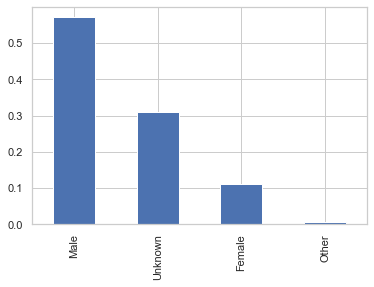

In [16]:
salaries.gender.replace('Title: Senior Software Engineer', np.nan, inplace=True)
salaries.gender.replace(np.nan, 'Unknown', inplace=True)

(salaries.gender.value_counts() / salaries.shape[0]).plot(kind='bar')

In [17]:
salaries = pd.concat([salaries, pd.get_dummies(salaries.gender, prefix='gender')], axis=1)
salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,yoe_over_20,yac_below_1,yac_between_10_20,yac_between_1_5,yac_between_5_10,yac_over_20,gender_Female,gender_Male,gender_Other,gender_Unknown
0,6/7/2017 11:33:27,Oracle,L3,Product_Manager,127000,"Redwood City, CA",1.500,1.500,NaN,107000.000,...,0,0,0,1,0,0,0,0,0,1
1,6/10/2017 17:11:29,eBay,SE 2,Software_Engineer,100000,"San Francisco, CA",5.000,3.000,NaN,0.000,...,0,0,0,1,0,0,0,0,0,1
2,6/11/2017 14:53:57,Amazon,L7,Product_Manager,310000,"Seattle, WA",8.000,0.000,NaN,155000.000,...,0,1,0,0,0,0,0,0,0,1
3,6/17/2017 0:23:14,Apple,M1,Software_Engineering_Manager,372000,"Sunnyvale, CA",7.000,5.000,NaN,157000.000,...,0,0,0,0,1,0,0,0,0,1
4,6/20/2017 10:58:51,Microsoft,60,Software_Engineer,157000,"Mountain View, CA",5.000,3.000,NaN,0.000,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software_Engineer,327000,"Seattle, WA",10.000,1.000,Distributed Systems (Back-End),155000.000,...,0,0,0,1,0,0,0,0,0,1
62638,9/13/2018 8:23:32,Microsoft,62,Software_Engineer,237000,"Redmond, WA",2.000,2.000,Full Stack,146900.000,...,0,0,0,1,0,0,0,0,0,1
62639,9/13/2018 14:35:59,MSFT,63,Software_Engineer,220000,"Seattle, WA",14.000,12.000,Full Stack,157000.000,...,0,0,1,0,0,0,0,0,0,1
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software_Engineer,280000,"San Francisco, CA",8.000,4.000,iOS,194688.000,...,0,0,0,1,0,0,0,0,0,1


### 2.6. Encoding `location`

For `location`, I take two different encoding based on the location's country, and if the location is common or not: 

In [18]:
#countries
salaries['country'] = salaries.location.str.split(pat=',').apply(lambda x:x[-1][1:])
salaries.loc[salaries.country.str.len() == 2,'country'] = 'US'
salaries.country.value_counts().head(10)

US                51834
India              2830
Canada             1791
United Kingdom     1182
Germany             575
Singapore           372
Ireland             316
Taiwan              306
Israel              296
Australia           261
Name: country, dtype: int64

In [19]:
salaries.location = salaries.location.str.replace(' ','_').str.replace(',','_')
top_10_locs = salaries.location.value_counts()[:10].index.to_list()
salaries = salaries.join(pd.get_dummies(salaries[salaries.location.isin(top_10_locs)].location))
salaries[top_10_locs] = salaries[top_10_locs].fillna(0)

salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Austin__TX,Cupertino__CA,Menlo_Park__CA,Mountain_View__CA,New_York__NY,Redmond__WA,San_Francisco__CA,San_Jose__CA,Seattle__WA,Sunnyvale__CA
0,6/7/2017 11:33:27,Oracle,L3,Product_Manager,127000,Redwood_City__CA,1.500,1.500,NaN,107000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,6/10/2017 17:11:29,eBay,SE 2,Software_Engineer,100000,San_Francisco__CA,5.000,3.000,NaN,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
2,6/11/2017 14:53:57,Amazon,L7,Product_Manager,310000,Seattle__WA,8.000,0.000,NaN,155000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
3,6/17/2017 0:23:14,Apple,M1,Software_Engineering_Manager,372000,Sunnyvale__CA,7.000,5.000,NaN,157000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
4,6/20/2017 10:58:51,Microsoft,60,Software_Engineer,157000,Mountain_View__CA,5.000,3.000,NaN,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software_Engineer,327000,Seattle__WA,10.000,1.000,Distributed Systems (Back-End),155000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
62638,9/13/2018 8:23:32,Microsoft,62,Software_Engineer,237000,Redmond__WA,2.000,2.000,Full Stack,146900.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
62639,9/13/2018 14:35:59,MSFT,63,Software_Engineer,220000,Seattle__WA,14.000,12.000,Full Stack,157000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software_Engineer,280000,San_Francisco__CA,8.000,4.000,iOS,194688.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000


In [20]:
top_10_countries = salaries.country.value_counts().head(10).index.to_list()
top_10_countries = [country.replace(' ', '_') for country in top_10_countries]
salaries.country = salaries.country.str.replace(' ','_')
salaries = salaries.join(pd.get_dummies(salaries[salaries.country.isin(top_10_countries)].country))
salaries[top_10_countries] = salaries[top_10_countries].fillna(0)

salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Australia,Canada,Germany,India,Ireland,Israel,Singapore,Taiwan,US,United_Kingdom
0,6/7/2017 11:33:27,Oracle,L3,Product_Manager,127000,Redwood_City__CA,1.500,1.500,NaN,107000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
1,6/10/2017 17:11:29,eBay,SE 2,Software_Engineer,100000,San_Francisco__CA,5.000,3.000,NaN,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,6/11/2017 14:53:57,Amazon,L7,Product_Manager,310000,Seattle__WA,8.000,0.000,NaN,155000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
3,6/17/2017 0:23:14,Apple,M1,Software_Engineering_Manager,372000,Sunnyvale__CA,7.000,5.000,NaN,157000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
4,6/20/2017 10:58:51,Microsoft,60,Software_Engineer,157000,Mountain_View__CA,5.000,3.000,NaN,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software_Engineer,327000,Seattle__WA,10.000,1.000,Distributed Systems (Back-End),155000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
62638,9/13/2018 8:23:32,Microsoft,62,Software_Engineer,237000,Redmond__WA,2.000,2.000,Full Stack,146900.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
62639,9/13/2018 14:35:59,MSFT,63,Software_Engineer,220000,Seattle__WA,14.000,12.000,Full Stack,157000.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software_Engineer,280000,San_Francisco__CA,8.000,4.000,iOS,194688.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000


### 2.7. Modify One-Hot Encodings of `Race` and `Education` 

In our EDA, we noticed several minor issues on one-hot encodings of `race` and `education`. Let's fix them: 

In [21]:
salaries.groupby([
    'Race','Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic'
]).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,Race,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,count
0,Asian,1,0,0,0,0,11636
5,White,0,1,0,0,0,7894
3,Hispanic,0,0,0,0,1,1122
4,Two Or More,0,0,1,0,0,791
2,Black,0,0,0,1,0,687
1,Asian,1,0,0,0,1,1


In [22]:
salaries.loc[(salaries.Race_Asian == 1) & (salaries.Race_Hispanic == 1), 'Race_Hispanic'] = 0

In [23]:
salaries.groupby([
    'Race','Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic'
]).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,Race,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,count
0,Asian,1,0,0,0,0,11637
4,White,0,1,0,0,0,7894
2,Hispanic,0,0,0,0,1,1122
3,Two Or More,0,0,1,0,0,791
1,Black,0,0,0,1,0,687


In [24]:
salaries.groupby([
    'Education','Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College'
]).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,Education,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,count
2,Master's Degree,1,0,0,0,0,15058
0,Bachelor's Degree,0,1,0,0,0,12481
5,PhD,0,0,1,0,0,1634
6,Some College,0,0,0,0,1,349
1,Highschool,0,0,0,1,0,318
3,Master's Degree,1,0,1,0,0,90
4,Master's Degree,1,1,0,0,0,4


In [25]:
salaries.loc[(salaries.Masters_Degree == 1) & (salaries.Doctorate_Degree == 1), 'Doctorate_Degree'] = 0
salaries.loc[(salaries.Masters_Degree == 1) & (salaries.Bachelors_Degree == 1), 'Bachelors_Degree'] = 0

In [26]:
salaries.groupby([
    'Education','Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College'
]).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,Education,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,count
2,Master's Degree,1,0,0,0,0,15152
0,Bachelor's Degree,0,1,0,0,0,12481
3,PhD,0,0,1,0,0,1634
4,Some College,0,0,0,0,1,349
1,Highschool,0,0,0,1,0,318


## 3. Model Fitting

### 3.1. Mean Model

Start with a mean model of the data.

In [27]:
salaries.totalyearlycompensation.describe()

count    61595.000
mean    207197.614
std     109004.728
min      10000.000
25%     135000.000
50%     186000.000
75%     260000.000
max     630000.000
Name: totalyearlycompensation, dtype: float64

In [28]:
(salaries.totalyearlycompensation.mean() - 2 * salaries.totalyearlycompensation.std(), \
 salaries.totalyearlycompensation.mean() + 2 * salaries.totalyearlycompensation.std())

(-10811.843003337795, 425207.0700834579)

The mean model predicts any STEM employee's total annual compensation to be $207,197.61 with the 2 std range: (-10,811.84, 425,207.07). Since the negative compensation does not make sense. The range would be (0.00, 425,207.07)

### 3.2. Linear Regression Model

Next, let's build a linear regression model. Starting with pick necessary columns to be regressors: 

In [29]:
salaries.columns

Index(['timestamp', 'company', 'level', 'title', 'totalyearlycompensation',
       'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary',
       'stockgrantvalue', 'bonus', 'gender', 'otherdetails', 'cityid', 'dmaid',
       'rowNumber', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree',
       'Highschool', 'Some_College', 'Race_Asian', 'Race_White',
       'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic', 'Race', 'Education',
       'year', 'month', 'year_month', 'year_month_delta', 'company_level',
       'company_level_mean_enc', 'is_common_company', 'Business_Analyst',
       'Data_Scientist', 'Hardware_Engineer', 'Human_Resources',
       'Management_Consultant', 'Marketing', 'Mechanical_Engineer',
       'Product_Designer', 'Product_Manager', 'Recruiter', 'Sales',
       'Software_Engineer', 'Software_Engineering_Manager',
       'Solution_Architect', 'Technical_Program_Manager', 'yoe_below_1',
       'yoe_between_10_20', 'yoe_between_1_5', 'yoe_between_

Most of the regressors will be fields generated by one-hot encoding. Let's create a list of regressors: 

In [30]:
title_enc = ['Business_Analyst', 'Data_Scientist',
       'Hardware_Engineer', 'Human_Resources', 'Management_Consultant',
       'Marketing', 'Mechanical_Engineer', 'Product_Designer',
       'Product_Manager', 'Recruiter', 'Sales', 'Software_Engineer',
       'Software_Engineering_Manager', 'Solution_Architect',
       'Technical_Program_Manager']

yoe_enc = ['yoe_below_1', 'yoe_between_10_20',
       'yoe_between_1_5', 'yoe_between_5_10', 'yoe_over_20']

yac_enc = ['yac_below_1',
       'yac_between_10_20', 'yac_between_1_5', 'yac_between_5_10',
       'yac_over_20']

gender_enc = ['gender_Female', 'gender_Male', 'gender_Other',
       'gender_Unknown']

top_loc_enc = ['Austin__TX', 'Cupertino__CA',
       'Menlo_Park__CA', 'Mountain_View__CA', 'New_York__NY', 'Redmond__WA',
       'San_Francisco__CA', 'San_Jose__CA', 'Seattle__WA', 'Sunnyvale__CA']

top_country_enc = ['Australia', 'Canada', 'Germany', 'India', 'Ireland', 'Israel',
       'Singapore', 'Taiwan', 'US', 'United_Kingdom']

race_enc = ['Race_Asian', 'Race_White',
       'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic']

education_enc = ['Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree',
       'Highschool', 'Some_College']

In [31]:
regressors = ['year_month_delta', 'company_level_mean_enc'] + title_enc + yoe_enc + yac_enc + gender_enc +\
                                                            top_loc_enc + top_country_enc + race_enc + education_enc

We start off with all encodings and two numerical variables: `year_month_delta` & `company_level_mean_enc`

In [32]:
import util.models as models

In [33]:
model = 'totalyearlycompensation ~ ' + ' + '.join(regressors)
result1 = models.bootstrap_linear_regression(model, data=salaries)
models.describe_bootstrap_lr(result1, sd=6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-31031.675078,-33346.820114,-28712.908324
year_month_delta,$\beta_{1}$,375.527103,330.913688,425.923166
company_level_mean_enc,$\beta_{2}$,0.871951,0.865876,0.879123
Business_Analyst,$\beta_{3}$,-16901.583110,-19997.095263,-14488.614020
Data_Scientist,$\beta_{4}$,11350.942009,9788.405883,12922.021509
Hardware_Engineer,$\beta_{5}$,9471.105556,7911.251444,11420.932378
Human_Resources,$\beta_{6}$,-35369.099687,-40600.101580,-30353.416828
Management_Consultant,$\beta_{7}$,8900.101776,6977.179818,10895.874069
Marketing,$\beta_{8}$,-25842.385967,-29647.744274,-22296.662568


This base model give $R^2$=0.827105, and the std of 45347.38. Let's check the residual plots: 

In [34]:
def plot_residuals(result, variables, data):
    figure = plt.figure(figsize=(20,10))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate(variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[1] for x in keyed_values]
        ordered_variables = [x[0] for x in keyed_values]

        axes.plot(ordered_variables, ordered_residuals, '.', color="dimgray", alpha=0.01)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

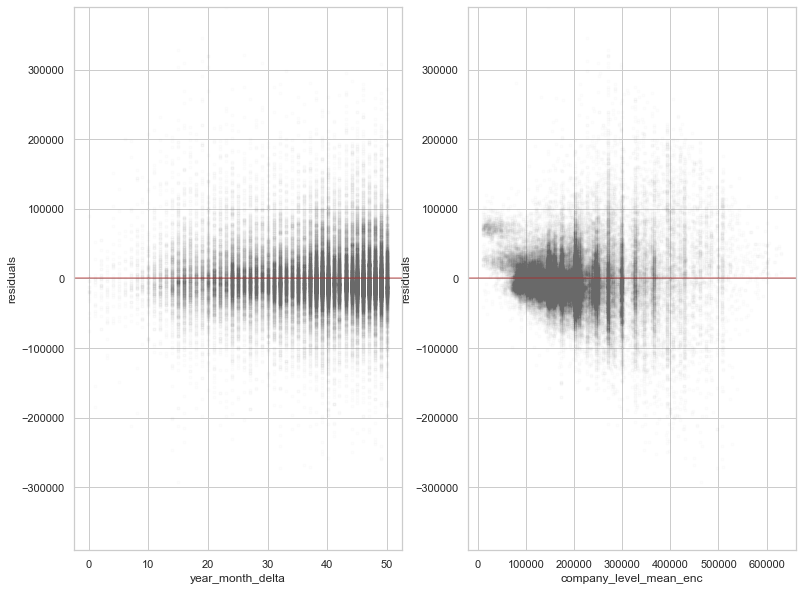

In [35]:
residuals1 = plot_residuals(result1, ['year_month_delta', 'company_level_mean_enc'], salaries)

Both residual plots showing funnel patterns. Since the number of submissions is increasing and the dataset can be thought as a time series one, so I'm not able to think of any possible improvement on the timestamp. Let's see if the model improves if we drop this date field from the regressors: 

In [36]:
regressors = ['company_level_mean_enc'] + title_enc + yoe_enc + yac_enc + gender_enc +\
                                                            top_loc_enc + top_country_enc + race_enc + education_enc

In [37]:
model = 'totalyearlycompensation ~ ' + ' + '.join(regressors)
result2 = models.bootstrap_linear_regression(model, data=salaries)
models.describe_bootstrap_lr(result2, sd=6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-23821.286144,-25880.370979,-21999.812885
company_level_mean_enc,$\beta_{1}$,0.870275,0.864828,0.876143
Business_Analyst,$\beta_{2}$,-16073.092362,-18718.126385,-13692.326386
Data_Scientist,$\beta_{3}$,11509.291366,9844.665167,13222.055844
Hardware_Engineer,$\beta_{4}$,10026.082277,8074.784591,11745.067351
Human_Resources,$\beta_{5}$,-34523.766476,-38471.905052,-29348.175240
Management_Consultant,$\beta_{6}$,9737.289339,7517.784896,12516.434786
Marketing,$\beta_{7}$,-24797.516335,-28740.674568,-20780.860673
Mechanical_Engineer,$\beta_{8}$,130.700630,-2777.040190,3760.774070


The second model gives a slightly lower $R^2$ and higher $\sigma$ than the first one. So we should keep the timestamp.


Let's see how the model will change if we replace the mean encoding of company & level to a boolean label of commom company: 

In [38]:
regressors = ['is_common_company'] + title_enc + yoe_enc + yac_enc + gender_enc +\
                                                            top_loc_enc + top_country_enc + race_enc + education_enc
model = 'totalyearlycompensation ~ ' + ' + '.join(regressors)
result3 = models.bootstrap_linear_regression(model, data=salaries)
models.describe_bootstrap_lr(result3, sd=6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-27193641800434.945312,-215870170401450.406250,80490684379684.140625
is_common_company,$\beta_{1}$,21460.216797,20209.763647,22938.186914
Business_Analyst,$\beta_{2}$,5881739214670537.000000,-265447084337755232.000000,396299955262211904.000000
Data_Scientist,$\beta_{3}$,5881739214724029.000000,-265447084337701856.000000,396299955262266240.000000
Hardware_Engineer,$\beta_{4}$,5881739214721675.000000,-265447084337705024.000000,396299955262266496.000000
Human_Resources,$\beta_{5}$,5881739214679774.000000,-265447084337746688.000000,396299955262222976.000000
Management_Consultant,$\beta_{6}$,5881739214697182.000000,-265447084337727040.000000,396299955262238336.000000
Marketing,$\beta_{7}$,5881739214684348.000000,-265447084337742464.000000,396299955262224960.000000
Mechanical_Engineer,$\beta_{8}$,5881739214689076.000000,-265447084337735424.000000,396299955262232064.000000


The model gets worse. So we should put the mean encoding back to the regressors. 

How about replacing years of expericen & yearsatcompany encoding to numerical values: 

In [39]:
regressors = ['year_month_delta', 'company_level_mean_enc', 'yearsofexperience', 'yearsatcompany'] +\
title_enc + gender_enc +top_loc_enc + top_country_enc + race_enc + education_enc
model = 'totalyearlycompensation ~ ' + ' + '.join(regressors)
result4 = models.bootstrap_linear_regression(model, data=salaries)
models.describe_bootstrap_lr(result4, sd=6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-44295.781103,-47195.259862,-41560.057317
year_month_delta,$\beta_{1}$,389.443416,339.748669,434.274550
company_level_mean_enc,$\beta_{2}$,0.872630,0.863924,0.878749
yearsofexperience,$\beta_{3}$,1545.370088,1437.659350,1656.420226
yearsatcompany,$\beta_{4}$,-840.950580,-974.315552,-693.275803
Business_Analyst,$\beta_{5}$,-17465.438413,-19572.197079,-15064.248417
Data_Scientist,$\beta_{6}$,10798.881301,9136.433333,12640.410132
Hardware_Engineer,$\beta_{7}$,8664.095497,6755.752941,10525.938376
Human_Resources,$\beta_{8}$,-36436.205143,-40619.900435,-30745.423109


There's a slight improvement compared to the first model. So I would keep the numerical years. Let's check the residual plots: 

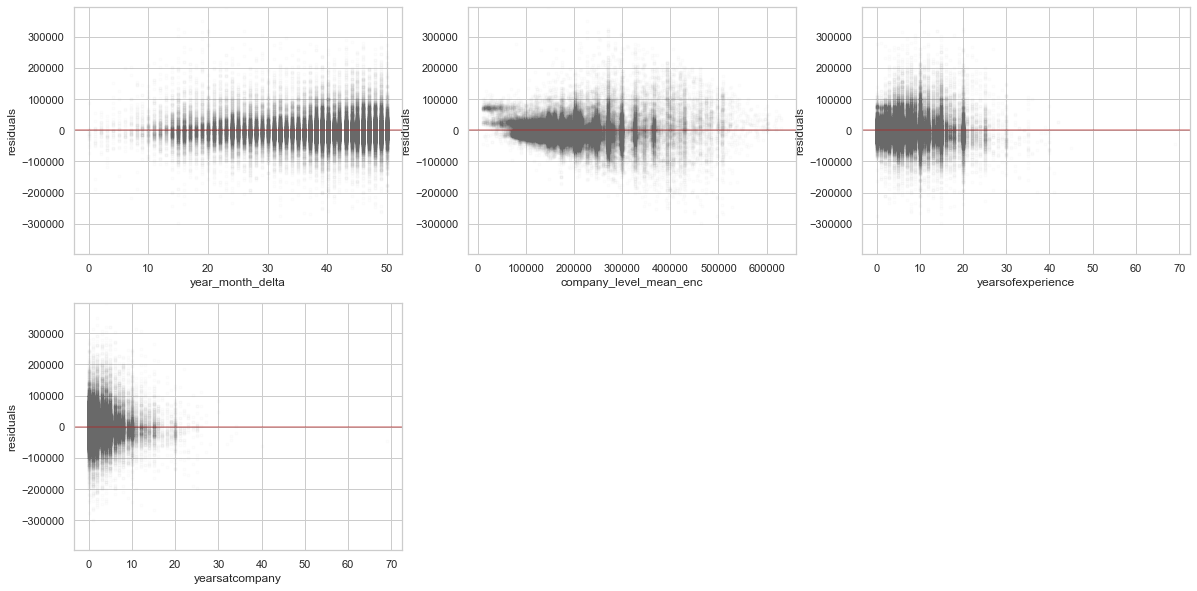

In [40]:
residuals4 = plot_residuals(result4, 
                            ['year_month_delta', 'company_level_mean_enc', 'yearsofexperience', 'yearsatcompany'], salaries)

The residual plots are not showing flat patterns. It might be a good idea to log convert the target variable, since in our EDA we noticed the right skewed pattern. 

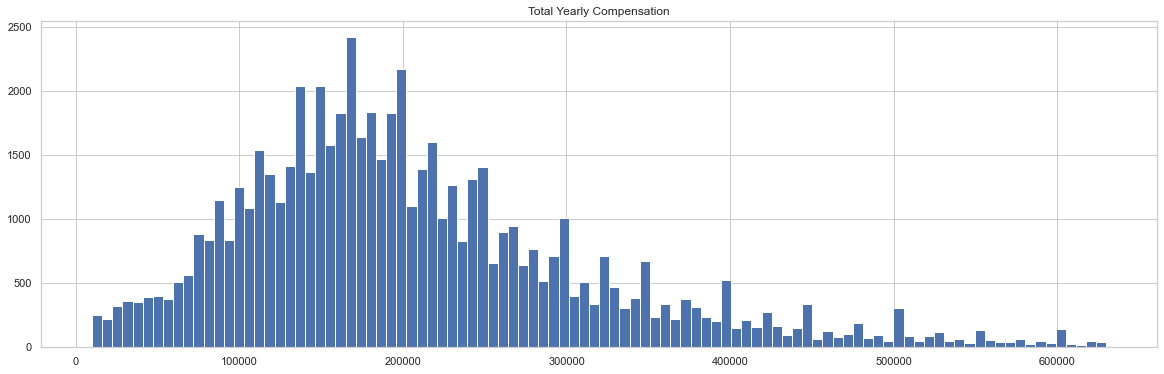

In [41]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(salaries.totalyearlycompensation, bins=100)
axes.set_title("Total Yearly Compensation")
plt.show()
plt.close()

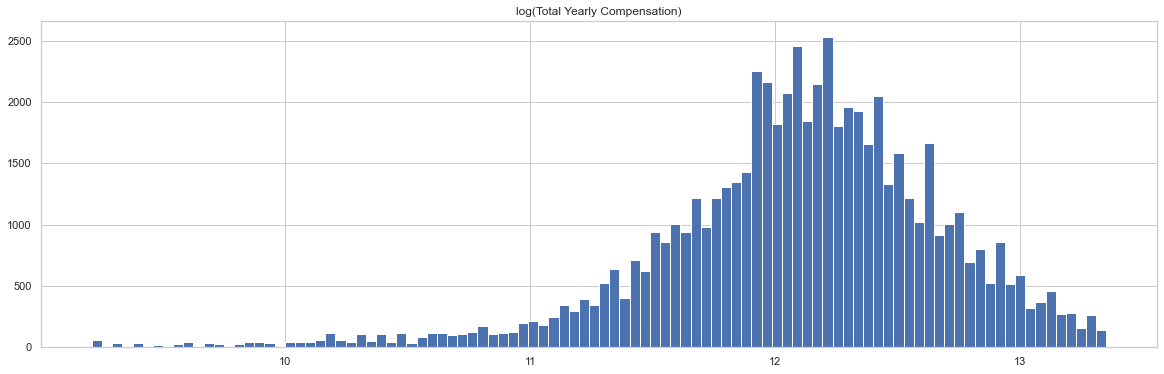

In [42]:
salaries['log_totalyearlycompensation'] = salaries.totalyearlycompensation.apply(np.log)
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(salaries.log_totalyearlycompensation, bins=100)
axes.set_title("log(Total Yearly Compensation)")
plt.show()
plt.close()

After log transformation, the distribution of the totay yearly compensentation looks normal. Let's fit another model and see the scores: 

In [43]:
regressors = ['year_month_delta', 'company_level_mean_enc', 'yearsofexperience', 'yearsatcompany']\
                + title_enc +  gender_enc + top_loc_enc + top_country_enc + race_enc + education_enc
    
model = 'log_totalyearlycompensation ~ ' + ' + '.join(regressors)
result5 = models.bootstrap_linear_regression(model, data=salaries)
models.describe_bootstrap_lr(result5, sd=6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,8.025027,8.002859,8.042773
year_month_delta,$\beta_{1}$,0.001407,0.001144,0.001640
company_level_mean_enc,$\beta_{2}$,0.000004,0.000004,0.000004
yearsofexperience,$\beta_{3}$,0.010085,0.009623,0.010622
yearsatcompany,$\beta_{4}$,-0.004414,-0.005118,-0.003614
Business_Analyst,$\beta_{5}$,0.384988,0.369561,0.405294
Data_Scientist,$\beta_{6}$,0.617143,0.608569,0.627448
Hardware_Engineer,$\beta_{7}$,0.611526,0.604189,0.620844
Human_Resources,$\beta_{8}$,0.331360,0.292142,0.358797


$R^2$ improved from 0.827127 to 0.832380. So this change is improving the model. 

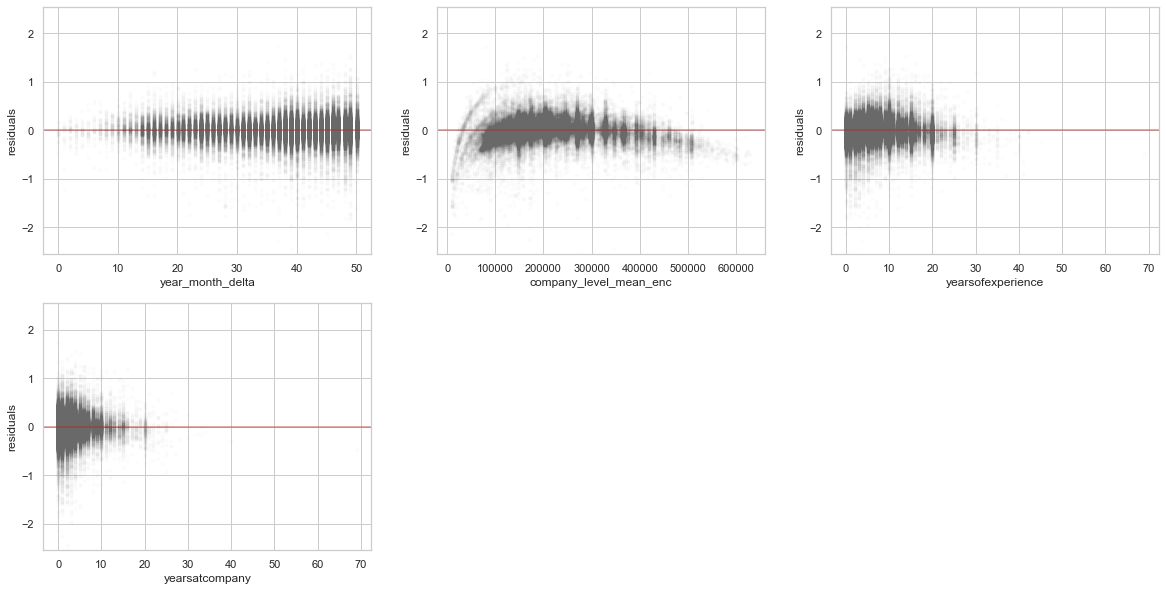

In [44]:
residuals5 = plot_residuals(result5, ['year_month_delta', 'company_level_mean_enc', 'yearsofexperience', 'yearsatcompany'], salaries)

From the residual plot, we can see the one for `company_level_mean_enc` is showing inverse-U shape, which is totally making sense since the unit of this variable should be the same as the target. Let's log transform this field as well: 

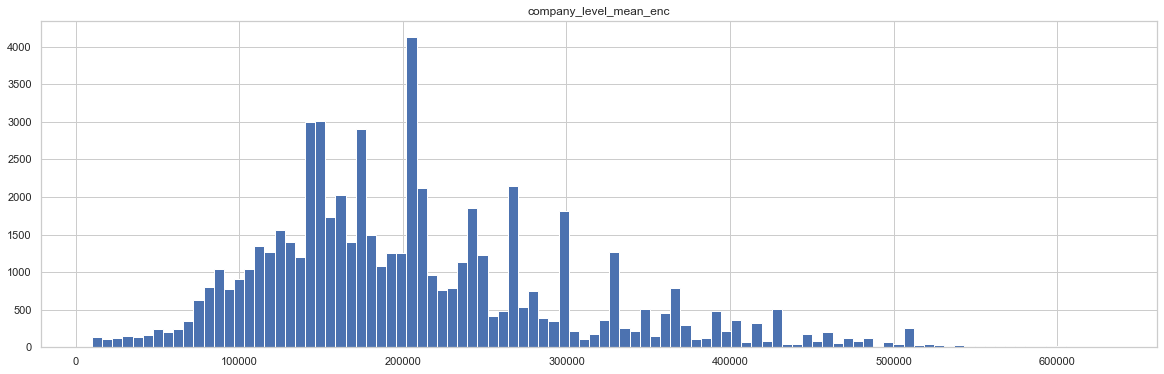

In [45]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(salaries.company_level_mean_enc, bins=100)
axes.set_title("company_level_mean_enc")
plt.show()
plt.close()

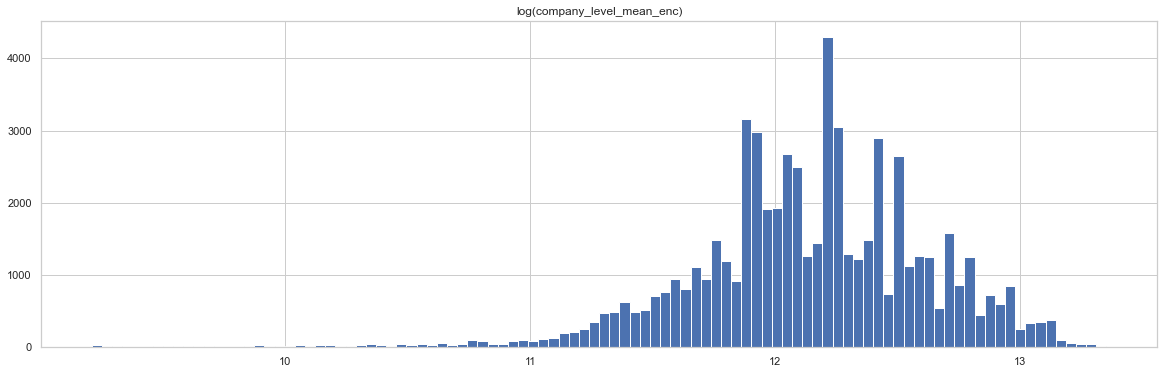

In [46]:
salaries['log_company_level_mean_enc'] = salaries.company_level_mean_enc.apply(np.log)

figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(salaries.log_company_level_mean_enc, bins=100)
axes.set_title("log(company_level_mean_enc)")
plt.show()
plt.close()

In [47]:
regressors = ['year_month_delta', 'log_company_level_mean_enc', 'yearsofexperience', 'yearsatcompany']\
                + title_enc +  gender_enc + top_loc_enc + top_country_enc + race_enc + education_enc
model = 'log_totalyearlycompensation ~ ' + ' + '.join(regressors)
result6 = models.bootstrap_linear_regression(model, data=salaries)
models.describe_bootstrap_lr(result6, sd=6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.501208,1.450135,1.557196
year_month_delta,$\beta_{1}$,0.001678,0.001515,0.001857
log_company_level_mean_enc,$\beta_{2}$,0.785646,0.779309,0.791635
yearsofexperience,$\beta_{3}$,0.010975,0.010562,0.011448
yearsatcompany,$\beta_{4}$,-0.005063,-0.005620,-0.004419
Business_Analyst,$\beta_{5}$,-0.018424,-0.033732,-0.005754
Data_Scientist,$\beta_{6}$,0.180418,0.170330,0.193188
Hardware_Engineer,$\beta_{7}$,0.164658,0.155452,0.175508
Human_Resources,$\beta_{8}$,-0.079533,-0.110410,-0.053456


Another improvement on $R^2$ & $\sigma$. 

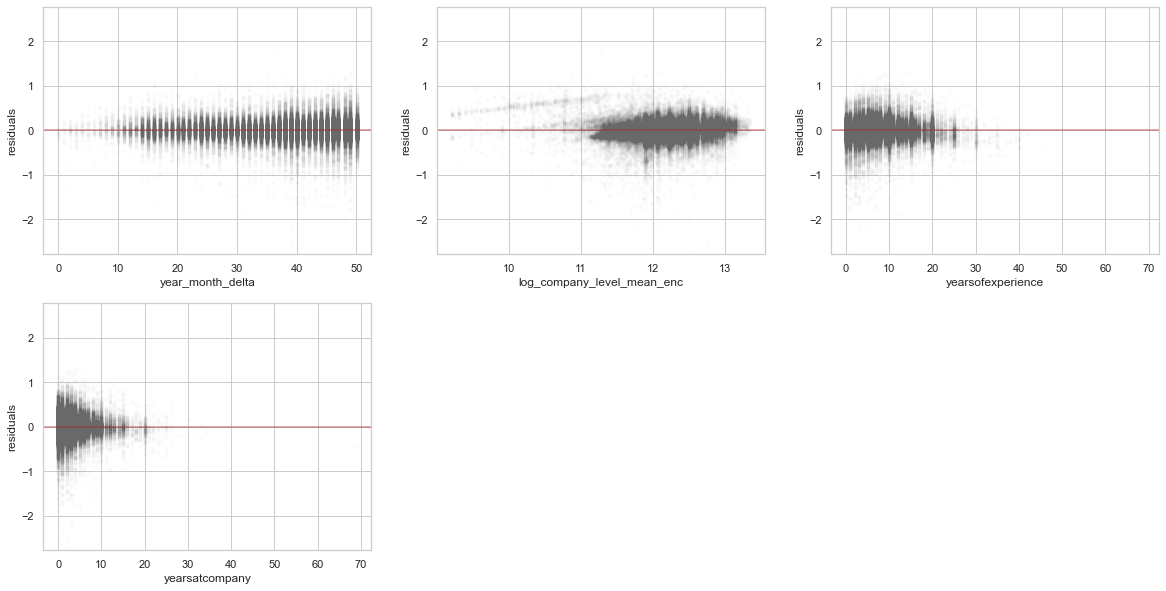

In [48]:
residuals6 = plot_residuals(result6, ['year_month_delta', 'log_company_level_mean_enc', 'yearsofexperience', 'yearsatcompany'], salaries)

The residual plot of `company_level_mean_enc` is relatively falt now. 

Let's add in an interaction term of `yearsatcompany` and `yearsofexperience`:

In [49]:
regressors = ['year_month_delta', 'log_company_level_mean_enc', 
              'yearsofexperience', 'yearsatcompany', 'yearsofexperience:yearsatcompany']\
                + title_enc +  gender_enc + top_loc_enc + top_country_enc + race_enc + education_enc
model = 'log_totalyearlycompensation ~ ' + ' + '.join(regressors)
result7 = models.bootstrap_linear_regression(model, data=salaries)
models.describe_bootstrap_lr(result7, sd=6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.513558,1.467469,1.573587
year_month_delta,$\beta_{1}$,0.001701,0.001522,0.001937
log_company_level_mean_enc,$\beta_{2}$,0.783119,0.775579,0.788936
yearsofexperience,$\beta_{3}$,0.011970,0.011515,0.012690
yearsatcompany,$\beta_{4}$,-0.000026,-0.001346,0.001780
yearsofexperience:yearsatcompany,$\beta_{5}$,-0.000348,-0.000471,-0.000268
Business_Analyst,$\beta_{6}$,-0.017205,-0.030041,-0.001683
Data_Scientist,$\beta_{7}$,0.182419,0.174793,0.193465
Hardware_Engineer,$\beta_{8}$,0.165673,0.156562,0.177033


The model's $R^2$ increased to 0.856753

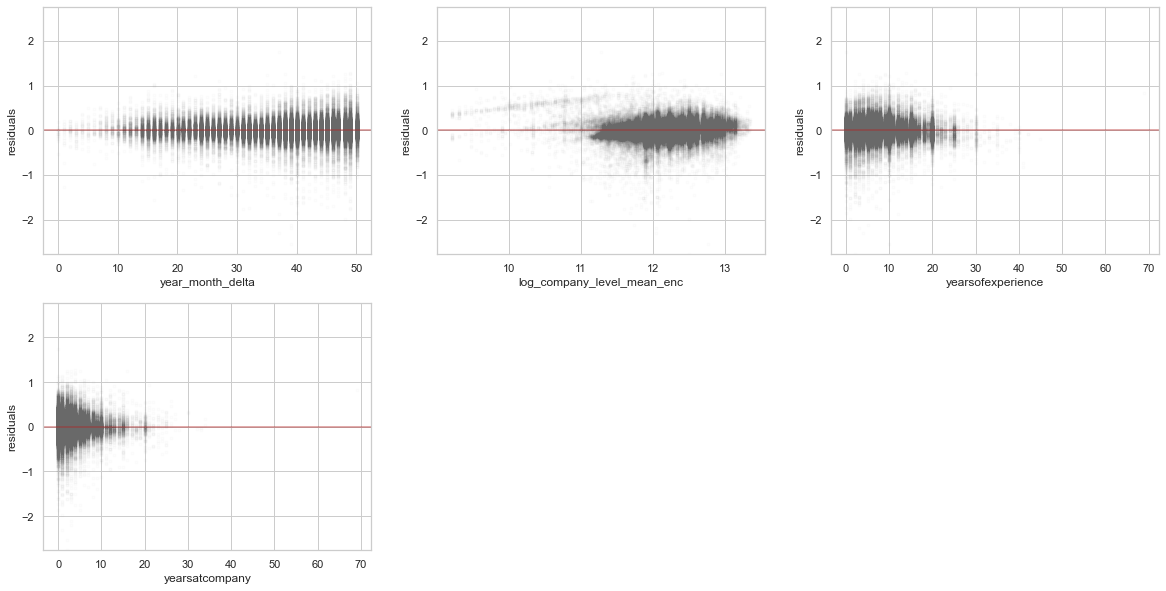

In [50]:
residuals7 = plot_residuals(result7, ['year_month_delta', 'log_company_level_mean_enc', 
              'yearsofexperience', 'yearsatcompany'], salaries)

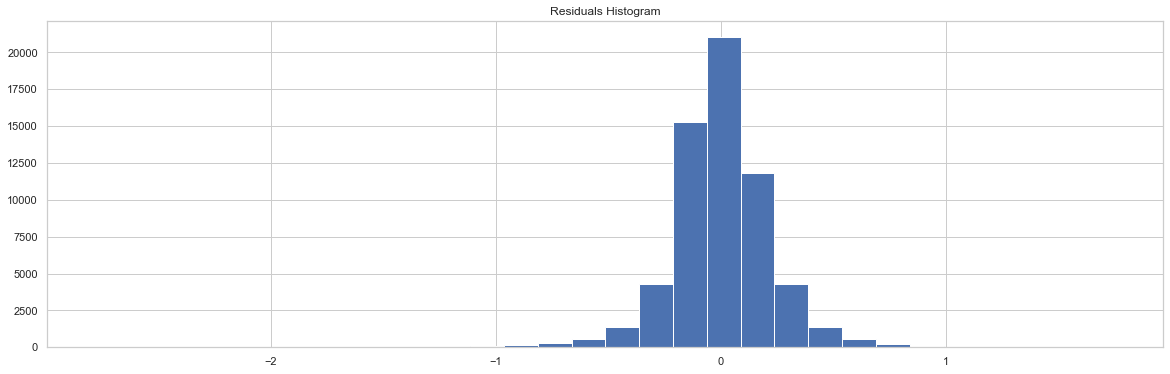

In [51]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(residuals7, bins=30)
axes.set_title("Residuals Histogram")
plt.show()
plt.close()  

The residuals looks normally distributed. Let's evaluate this as a final model.

## 4. Final Model Evaluation

Our final model is 'year_month_delta' + 'log_company_level_mean_enc' + 'yearsofexperience' + 'yearsatcompany' + 'yearsofexperience:yearsatcompany' + title encodings +  gender encodings + top location encodings + top country encodings + race encodings + education encodings. 

To evaluate this model, we can start with three rounds of 10-fold CV:

In [52]:
regressors = ['year_month_delta', 'log_company_level_mean_enc', 
              'yearsofexperience', 'yearsatcompany', 'yearsofexperience:yearsatcompany']\
                + title_enc +  gender_enc + top_loc_enc + top_country_enc + race_enc + education_enc
model = 'log_totalyearlycompensation ~ ' + ' + '.join(regressors)
final = models.bootstrap_linear_regression(model, data=salaries)
models.describe_bootstrap_lr(final, sd=6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.513558,1.468048,1.575361
year_month_delta,$\beta_{1}$,0.001701,0.001472,0.001933
log_company_level_mean_enc,$\beta_{2}$,0.783119,0.775784,0.789203
yearsofexperience,$\beta_{3}$,0.011970,0.011379,0.012438
yearsatcompany,$\beta_{4}$,-0.000026,-0.001455,0.002120
yearsofexperience:yearsatcompany,$\beta_{5}$,-0.000348,-0.000482,-0.000244
Business_Analyst,$\beta_{6}$,-0.017205,-0.032895,-0.002376
Data_Scientist,$\beta_{7}$,0.182419,0.174064,0.192341
Hardware_Engineer,$\beta_{8}$,0.165673,0.155013,0.174568


In [53]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [54]:
result = cross_validation(models.linear_regression, model, salaries, lambda r: (r["sigma"], r["r_squared"]))

In [55]:
sigmas = [r[0] for r in result]
r_squareds = [r[1] for r in result]
print("mean sigma: ", np.mean(sigmas))
print(r"95% CI for sigma:", stats.mstats.mquantiles(sigmas, [0.025, 0.975]))

print("mean R^2: ", np.mean(r_squareds))
print(r"95% CI for R^2:", stats.mstats.mquantiles(r_squareds, [0.025, 0.975]))

mean sigma:  0.22425956370340402
95% CI for sigma: [0.21504521 0.23411319]
mean R^2:  0.8566539610129797
95% CI for R^2: [0.84833728 0.86527976]


The results of 3 rounds of 10 fold CV are quite aligned with our latest result. On average, the mean $R^2$  is 0.86, and the error $\sigma$ is 0.22

Let's plot learning curves to see if more data will improve the model or not:

In [56]:
from collections import defaultdict

def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=5):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results


In [57]:
result = learning_curves(models.linear_regression, model, salaries, lambda r: r["sigma"])

In [58]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

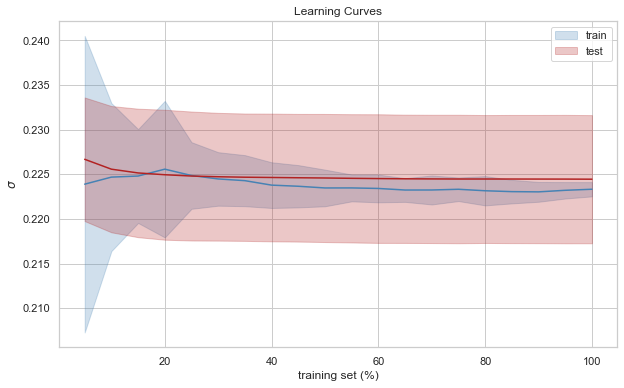

In [59]:
plot_learning_curves(result, r"$\sigma$")

The plot above shows for both training and test sets, the error starts being stable with the set size around 5%. So we can say no more data is needed for the further training.

## 5. Model Prediction

Now we can use our model to make some prediction. Let's pick a random person from the dataset and predict his/her yearly compensation.

In [60]:
sample = salaries.sample(1, random_state=202205)[['totalyearlycompensation','year_month_delta', 'log_company_level_mean_enc', 
              'yearsofexperience', 'yearsatcompany']
                + title_enc +  gender_enc + top_loc_enc + top_country_enc + race_enc + education_enc]
sample

,totalyearlycompensation,year_month_delta,log_company_level_mean_enc,yearsofexperience,yearsatcompany,Business_Analyst,Data_Scientist,Hardware_Engineer,Human_Resources,Management_Consultant,...,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College
48622,164000,45.997,12.008,8.000,8.000,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [61]:
sample['yearsofexperience:yearsatcompany'] = sample.yearsofexperience * sample.yearsatcompany
sample_X = sample[['year_month_delta', 'log_company_level_mean_enc', 
              'yearsofexperience', 'yearsatcompany', 'yearsofexperience:yearsatcompany']
                + title_enc +  gender_enc + top_loc_enc + top_country_enc + race_enc + education_enc]
X = [1] + sample_X.iloc[0,:].to_list()

With the Null model, we can predicit total yearly compensation with log transformation:

In [62]:
log_mean = salaries.log_totalyearlycompensation.mean()
log_std = salaries.log_totalyearlycompensation.std()

[np.exp(x) for x in [log_mean - 1.96*log_std, log_mean, log_mean + 1.96*log_std]]

[56130.91069263043, 178353.2123808418, 566708.5741892669]

The mean prediction is 178353.21 with a range of 56130.91 to 566708.57 (range size=510577.66).

Let's see how our linear regression model does:

In [63]:
prediction = final['model'].predict([X])
np.exp(prediction[0][0])

130930.22938091525

In [64]:
[np.exp(x) for x in [prediction[0][0] - 1.96 * final["sigma"], prediction[0][0] + 1.96 * final["sigma"]]]

[84514.25245084944, 202838.2724642651]

The model gives a prediction for this person: $ 130,930.23, with an error bounds of 84514.25 ~ 202838.27. The true compensation is 164,000. Even though the prediction value is a bit off from the true number, but the range of error bounds is much smaller than the one from the Null model: 118,324.02 vs 510,577.66. 

Let's try this model on an imaginary person: Seattle based Amazon L4 Data Scientist, Asian Male with M.A. degree. Year of Experience = 1, Year at company = 5, the report submitted on May 1st, 2022. His true total compensation is 185K: 

In [65]:
# first check the log company level mean encoding: 
salaries[salaries.company_level == 'amazon - l4'].log_company_level_mean_enc.head(1)

34   11.893
Name: log_company_level_mean_enc, dtype: float64

Then create a list of regressors including intercept = 1:

In [66]:
# year_month_delta + log_company_level_mean_enc + yearsofexperience + yearsatcompany + yearsofexperience:yearsatcompany
# + Business_Analyst + Data_Scientist + Hardware_Engineer + Human_Resources + Management_Consultant + Marketing + 
# Mechanical_Engineer + Product_Designer + Product_Manager + Recruiter + Sales + Software_Engineer + 
# Software_Engineering_Manager + Solution_Architect + Technical_Program_Manager + gender_Female + gender_Male + 
# gender_Other + gender_Unknown + Austin__TX + Cupertino__CA + Menlo_Park__CA + Mountain_View__CA + New_York__NY + 
# Redmond__WA + San_Francisco__CA + San_Jose__CA + Seattle__WA + Sunnyvale__CA + Australia + Canada + Germany + India + 
# Ireland + Israel + Singapore + Taiwan + US + United_Kingdom + Race_Asian + Race_White + Race_Two_Or_More + Race_Black + 
# Race_Hispanic + Masters_Degree + Bachelors_Degree + Doctorate_Degree + Highschool + Some_College

another_X = [1, 59, 11.893, 1, 5, 1*5, 
 0, 1, 0, 0, 0, 0, 
 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 1,
 0, 0, 0, 0, 0, 0, 0, 
 0, 0, 0, 1, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 
 0, 1, 0, 0, 0, 0]

prediction = final['model'].predict([another_X])
np.exp(prediction[0][0])

164911.89665757737

In [67]:
[np.exp(x) for x in [prediction[0][0] - 1.96 * final["sigma"], prediction[0][0] + 1.96 * final["sigma"]]]

[106449.10447471074, 255482.97276338717]

For this imaginary person, the model gives a prediction: $ 164,911.90, with an error bounds of 106,449.10 ~ 255,482.97. 